# Predicting churn with PySpark

### Overview

Customer churn is when an existing customer, user, subscriber or any kind of return client stops doing business or ends the relationship with a company or service. Not surprisingly, **Churn Rate** is one of the most important KPIs for many services and is a good measurement of business' health. Predicting churn is a fundamental task to help Customer Success teams take action and avoid loss of customers and revenue.

### Project Objectives

In this project, we are going to use a 128MB subset of a larger dataset (with more than 12GB) with activity logs generated by users of a fictional music streaming service called Sparkify to train a machine learning model. For that we are going to use PySpark API over Spark engine, which is built to work with large-scale data processing, to perform all necessary steps from data cleaning to model training. By the end we expect to have a trained machine learning model capable of identifying users about to churn.

### Metrics

To measure the performance of our model we are going to use two main metrics: Area Under the Precision-Recall Curve **(AUC-PR)** and **F1-score**. We picked these metrics instead of accuracy, for example, due to the characteristics of the problem. As the number of users who churn is usually much smaller than the total number of users, just predicting that no user will churn would give us a good accuracy level and this is not useful. AUC-PR is a good metric in this case because it is scale-invariant. Besides that, for the churn prediction problem a false negative is much more harmful than a false positive, so AUC-PR and F1-score will help us to have good precision and recall.

In [1]:
!source activate py36
!pip install httpagentparser
!pip install findspark

'source' não é reconhecido como um comando interno
ou externo, um programa operável ou um arquivo em lotes.


In [2]:
# This little hack was necessary to make Spark to correctly work with Jupyter in Windows 
import findspark

findspark.init()

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import httpagentparser

import matplotlib.pyplot as plt

from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, col, first, last, split, udf, when
from pyspark.sql.functions import sum as f_sum
from pyspark.sql.types import StringType, TimestampType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, LinearSVC, RandomForestClassifier, GBTClassifier
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, MaxAbsScaler
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [4]:
# Create a Spark session
spark = SparkSession.builder.appName('Sparkify').getOrCreate()

In [5]:
# Check configuration
spark.sparkContext.getConf().getAll()

[('spark.driver.host', 'DESKTOP-ENJ7IAI'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.name', 'Sparkify'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.port', '64194'),
 ('spark.app.id', 'local-1594006676396'),
 ('spark.ui.showConsoleProgress', 'true')]

In [6]:
# To make sure to use same timezone independently from where it is running
spark.conf.set('spark.sql.session.timeZone', 'Etc/UTC')

## Data Analysis

Some questions we should try to answer at this initial point are:

* What the data looks like? (Size, dimensions, structure...)
* Are there any abnormalities we need to address?
* Do we need to transform data in some way?

Let's start loading the data and getting some understanding about its structure.

In [7]:
# Load data
df = spark.read.json('mini_sparkify_event_data.json')

# DataFrame structure
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
# DataFrame shape
(df.count(), len(df.columns))

(286500, 18)

In [9]:
# Data overview
df.show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Bost

In [10]:
# Checking for duplicate log entries
df.count() - df.dropDuplicates().count()

0

From these first results we have been able to learn that our dataset is formed by activity logs, it has 286,500 logs and the main entity here are users' activities and not the users themselves. Since we want to determine churn probability based on users, it seems we will indeed need to perform some transformation.

We need to transform this activity-oriented dataset to a user-oriented dataset that we can use as input to our machine learning algorithm. We'll have to use 'userId' as an identifier, so let's check for further abnormalities and analyze if 'sessionId' could also be used to uniquely identify a user.

In [11]:
# Checking for null values in 'userId' column
df.filter(df.userId.isNull()).count()

0

In [12]:
# Checking for empty values in 'userId' column
df.filter(df.userId == '').count()

8346

In [13]:
# Let's see if we can rely in 'sessionId' to identify user activities when 'userId' is empty
# Checking for null values in 'sessionId' column
df.filter(df.sessionId.isNull()).count()

0

In [14]:
# Checking for empty values in 'sessionId' column
df.filter(df.sessionId == '').count()

0

In [15]:
# Inspecting 'sessionId' and 'userId' relation
df.select(['sessionId', 'userId']).where((df.userId != '') & (df.sessionId < 10)).dropDuplicates().sort('sessionId').show()

+---------+------+
|sessionId|userId|
+---------+------+
|        1|300001|
|        1|     2|
|        1|100001|
|        2|200002|
|        3|100003|
|        3|300003|
|        4|100004|
|        5|     6|
|        5|100005|
|        6|100006|
|        6|300006|
|        7|200007|
|        8|     9|
|        9|    10|
|        9|300009|
|        9|100009|
+---------+------+



As we can see, one 'sessionId' can be related to activities from more than one user, so it can't be used as an identifier. Since we don't know to which user they belong, we have no option other than to remove logs without 'userId'.

In [16]:
# Removing logs that doesn't have 'userId'
df = df.filter(df.userId != '')
(df.count(), len(df.columns))

(278154, 18)

The next step is to find out how many users have had their activities logged in our dataset.

In [17]:
# Counting users
df.select('userId').dropDuplicates().count()

225

Another useful piece of information is to know the time window for which the logs were collected. To know that, we need to convert the timestamps in 'ts' column to a readable date and time format and then sort accordingly.

In [18]:
# Convert timestamps into datetime format for further analysis
df = df.withColumn('registrationDatetime', (df['registration'] / 1000).cast(TimestampType()).cast(StringType()))
df = df.withColumn('tsDatetime', (df['ts'] / 1000).cast(TimestampType()).cast(StringType()))

In [19]:
# Sorting in ascending order to identify the beginning of the recording
df.select('ts', 'tsDatetime').sort('ts').show()

+-------------+-------------------+
|           ts|         tsDatetime|
+-------------+-------------------+
|1538352117000|2018-10-01 00:01:57|
|1538352180000|2018-10-01 00:03:00|
|1538352394000|2018-10-01 00:06:34|
|1538352416000|2018-10-01 00:06:56|
|1538352676000|2018-10-01 00:11:16|
|1538352678000|2018-10-01 00:11:18|
|1538352886000|2018-10-01 00:14:46|
|1538352899000|2018-10-01 00:14:59|
|1538352905000|2018-10-01 00:15:05|
|1538353084000|2018-10-01 00:18:04|
|1538353146000|2018-10-01 00:19:06|
|1538353150000|2018-10-01 00:19:10|
|1538353218000|2018-10-01 00:20:18|
|1538353375000|2018-10-01 00:22:55|
|1538353376000|2018-10-01 00:22:56|
|1538353441000|2018-10-01 00:24:01|
|1538353576000|2018-10-01 00:26:16|
|1538353668000|2018-10-01 00:27:48|
|1538353687000|2018-10-01 00:28:07|
|1538353744000|2018-10-01 00:29:04|
+-------------+-------------------+
only showing top 20 rows



In [20]:
# Identifying the end of the recording
df.select('ts', 'tsDatetime').sort('ts', ascending=False).show()

+-------------+-------------------+
|           ts|         tsDatetime|
+-------------+-------------------+
|1543799476000|2018-12-03 01:11:16|
|1543622579000|2018-12-01 00:02:59|
|1543622432000|2018-12-01 00:00:32|
|1543622411000|2018-12-01 00:00:11|
|1543622398000|2018-11-30 23:59:58|
|1543622395000|2018-11-30 23:59:55|
|1543622365000|2018-11-30 23:59:25|
|1543622355000|2018-11-30 23:59:15|
|1543622320000|2018-11-30 23:58:40|
|1543622287000|2018-11-30 23:58:07|
|1543622282000|2018-11-30 23:58:02|
|1543622248000|2018-11-30 23:57:28|
|1543622193000|2018-11-30 23:56:33|
|1543622173000|2018-11-30 23:56:13|
|1543622164000|2018-11-30 23:56:04|
|1543622122000|2018-11-30 23:55:22|
|1543622121000|2018-11-30 23:55:21|
|1543622093000|2018-11-30 23:54:53|
|1543622086000|2018-11-30 23:54:46|
|1543622052000|2018-11-30 23:54:12|
+-------------+-------------------+
only showing top 20 rows



It's reasonable to assume that the recordings started on 1st of October 2018 and stopped just before 1st of December 2012. There are some few outliers and we will just remove them.

In [21]:
# Default observation start and end
default_start_ts = 1538352000000 # 2018-10-01 00:00:00
default_end_ts = 1543622400000 # 2018-12-01 00:00:00

df = df.filter(df.ts < default_end_ts)
(df.count(), len(df.columns))

(278150, 20)

As our next step, we are going to take a look at our categorical features. But before that, let's see if we can transform 'location' and 'userAgent' into something more useful. The way they are at the moment we can't use them as categorical features in our model. Let's try to extract the State from 'location' and the operational system and browser from 'userAgent' and check how many categories we get from those.

In [22]:
# Extracting State from 'location'
df = df.withColumn('locationState', split(col('location'), ', ').getItem(1))

# Defining some functions to extract OSs and browsers from 'userAgent'
extract_os_udf = udf(lambda s: httpagentparser.detect(s).get('os', dict()).get('name', None) if s is not None else None, StringType())
extract_browser_udf = udf(lambda s: httpagentparser.detect(s).get('browser', dict()).get('name', None) if s is not None else None, StringType())

df = df.withColumn('os', extract_os_udf(col('userAgent')))
df = df.withColumn('browser', extract_browser_udf(col('userAgent')))

In [23]:
# Exploring possible values of main categorical features
df_pd = df.toPandas()
df_pd.auth.unique(), df_pd.gender.unique(), df_pd.level.unique(), df_pd.locationState.unique(), df_pd.method.unique(), df_pd.page.unique(), df_pd.status.unique(), df_pd.os.unique(), df_pd.browser.unique()

(array(['Logged In', 'Cancelled'], dtype=object),
 array(['M', 'F'], dtype=object),
 array(['paid', 'free'], dtype=object),
 array(['CA', 'MA-NH', 'FL', 'WA', 'MD', 'CO', 'TX', 'GA-AL', 'AZ',
        'NY-NJ-PA', 'PA-NJ-DE-MD', 'GA', 'IL-MO', 'OH', 'TN-VA', 'SC-NC',
        'WV', 'MN-WI', 'OK', 'CT', 'KY', 'VA-NC', 'KY-IN', 'NJ', 'UT',
        'PA-NJ', 'NE-IA', 'NC-SC', 'NH', 'MS', 'VA', 'PA', 'AL',
        'DC-VA-MD-WV', 'IL-IN-WI', 'MI', 'MO-KS', 'NY', 'IN', 'NV', 'MT',
        'WI', 'NC', 'IA', 'TN-MS-AR', 'AK', 'RI-MA', 'IL', 'MO-IL',
        'OH-KY-IN', 'LA', 'OR', 'AR', 'SC', 'MD-WV', 'UT-ID', 'OR-WA',
        'TN'], dtype=object),
 array(['PUT', 'GET'], dtype=object),
 array(['NextSong', 'Add to Playlist', 'Roll Advert', 'Thumbs Up',
        'Downgrade', 'Thumbs Down', 'Home', 'Logout', 'Help', 'Upgrade',
        'Add Friend', 'Settings', 'Submit Upgrade', 'About',
        'Submit Downgrade', 'Error', 'Save Settings', 'Cancel',
        'Cancellation Confirmation'], dtype=object),

The main goal of this project is to predict churn, but first we need to identify when a user has churned. How could we do that with the features we have? From the above results, 'auth' seems to be promising, so let's explore it further.

In [24]:
# Exploring 'auth' distribution
df.groupby('auth').count().show()

+---------+------+
|     auth| count|
+---------+------+
|Cancelled|    52|
|Logged In|278098|
+---------+------+



In [25]:
# Listing all logs with 'auth'='Cancelled'
df.select(['userId', 'auth', 'tsDatetime']).where(df.auth == 'Cancelled').sort('tsDatetime').show(52)

+------+---------+-------------------+
|userId|     auth|         tsDatetime|
+------+---------+-------------------+
|100011|Cancelled|2018-10-01 18:04:45|
|100001|Cancelled|2018-10-02 16:36:45|
|100024|Cancelled|2018-10-04 23:17:18|
|300007|Cancelled|2018-10-05 02:08:58|
|100006|Cancelled|2018-10-05 15:24:30|
|    18|Cancelled|2018-10-07 20:26:30|
|100019|Cancelled|2018-10-07 22:57:51|
|    32|Cancelled|2018-10-08 21:10:46|
|100003|Cancelled|2018-10-11 16:19:41|
|   125|Cancelled|2018-10-12 04:35:18|
|   105|Cancelled|2018-10-12 20:17:21|
|    17|Cancelled|2018-10-13 21:19:44|
|100023|Cancelled|2018-10-14 00:00:37|
|   143|Cancelled|2018-10-15 07:34:14|
|200001|Cancelled|2018-10-15 18:55:20|
|   101|Cancelled|2018-10-16 22:30:37|
|   129|Cancelled|2018-10-17 00:29:21|
|   121|Cancelled|2018-10-17 07:02:29|
|    51|Cancelled|2018-10-17 07:39:32|
|100005|Cancelled|2018-10-19 17:57:05|
|    87|Cancelled|2018-10-20 15:49:16|
|   122|Cancelled|2018-10-20 19:01:08|
|100017|Cancelled|2018-10

In [26]:
# Tracking down all activities from the first user to have 'auth'='Cancelled'
df.where(df.userId == '100011').select(['userId','itemInSession','auth','level','page','tsDatetime']).show(100)

+------+-------------+---------+-----+--------------------+-------------------+
|userId|itemInSession|     auth|level|                page|         tsDatetime|
+------+-------------+---------+-----+--------------------+-------------------+
|100011|            0|Logged In| free|                Home|2018-10-01 17:20:22|
|100011|            1|Logged In| free|            NextSong|2018-10-01 17:20:56|
|100011|            2|Logged In| free|                Home|2018-10-01 17:21:03|
|100011|            3|Logged In| free|            NextSong|2018-10-01 17:27:47|
|100011|            4|Logged In| free|         Roll Advert|2018-10-01 17:27:47|
|100011|            5|Logged In| free|            NextSong|2018-10-01 17:30:56|
|100011|            6|Logged In| free|                Home|2018-10-01 17:31:44|
|100011|            7|Logged In| free|            NextSong|2018-10-01 17:34:45|
|100011|            8|Logged In| free|            NextSong|2018-10-01 17:39:17|
|100011|            9|Logged In| free|  

Great! It looks like 'auth' is equal to 'Cancelled' at the last log when a user churns. We'll be able to use it to create the target label for our classifier. More than that, we now know that from the 225 total users, 52 churned and 173 don't. This proves right our initial guess of an imbalanced dataset.

Next, based on the way web services work, we may make another guess that features 'page', 'method' and 'status' are probably correlated. Method and status probably refer to the HTTP access to a web page, which is probably tightly related to the 'page' feature. Let's check how they interact with 'auth'.

In [27]:
# Exploring 'auth', 'method', 'status' and 'page' correlation
df.select(['auth', 'method', 'status', 'page']).dropDuplicates().sort(['auth', 'method', 'status']).show()

+---------+------+------+--------------------+
|     auth|method|status|                page|
+---------+------+------+--------------------+
|Cancelled|   GET|   200|Cancellation Conf...|
|Logged In|   GET|   200|               About|
|Logged In|   GET|   200|                Home|
|Logged In|   GET|   200|            Settings|
|Logged In|   GET|   200|         Roll Advert|
|Logged In|   GET|   200|                Help|
|Logged In|   GET|   200|             Upgrade|
|Logged In|   GET|   200|           Downgrade|
|Logged In|   GET|   404|               Error|
|Logged In|   PUT|   200|            NextSong|
|Logged In|   PUT|   200|     Add to Playlist|
|Logged In|   PUT|   307|       Save Settings|
|Logged In|   PUT|   307|          Add Friend|
|Logged In|   PUT|   307|           Thumbs Up|
|Logged In|   PUT|   307|              Cancel|
|Logged In|   PUT|   307|              Logout|
|Logged In|   PUT|   307|    Submit Downgrade|
|Logged In|   PUT|   307|      Submit Upgrade|
|Logged In|  

Those are all possible combinations of the four features ('auth', 'method', 'status', 'page') and luckily they are not as many as they could be. Each 'page' value maps to only one value of 'auth', 'method' and 'status', so we only need to keep 'page' as a feature to our model (although we are going to use 'auth' to create our label, we could just use 'page'='Cancellation Confirmation' for that too).

To finish this first analysis on 'page', let's check how it is distributed:

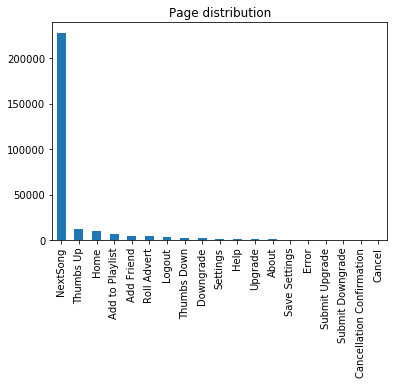

In [28]:
# Distrbution for 'page'
df_pd['page'].value_counts().plot(kind='bar', title='Page distribution');

As we can see, page distribution is highly imbalanced. 'Next Song' represents roughly 90% of all 'page' logs. We need to keep this in mind when we are going to perform further feature engineering.

Back to the features we've transformed earlier, we should decide if it makes sense to keep them as input. First of all, it seems that there are a lot of possible values for 'locationState', let's see how many they are and how they are distributed over the activities log dataset.

In [29]:
# Number of possible values for 'locationState'
len(df_pd.locationState.unique())

58

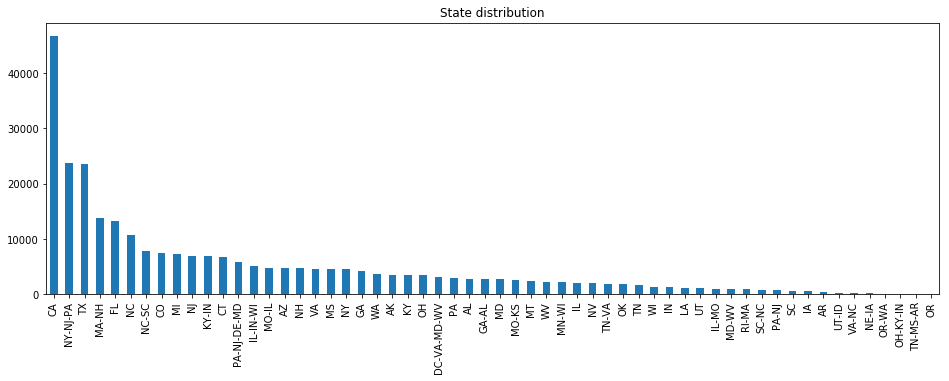

In [30]:
# Distrbution for 'locationState'
plt.figure(figsize=(16,5))
df_pd['locationState'].value_counts().plot(kind='bar', title='State distribution');

There are more possible values for 'locationState' than users who churned in our dataset. This makes this feature a bad candidate for input to our model, since churned users may be underrepresented by it, so we are going to drop it. Next, let's build more visualizations on distributions for the remaining categorical features.

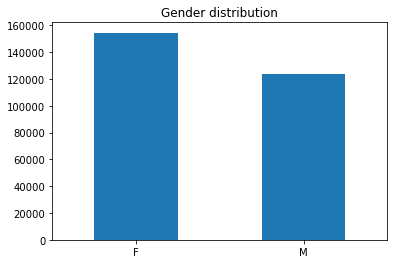

In [31]:
# Distribution for 'gender'
df_pd['gender'].value_counts().plot(kind='bar', rot=0, title='Gender distribution');

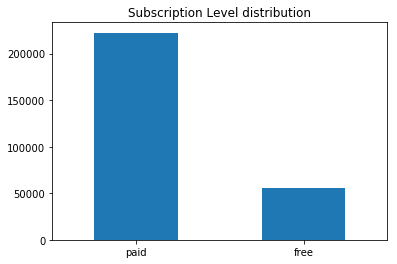

In [32]:
# Distribution for 'level'
df_pd['level'].value_counts().plot(kind='bar', rot=0, title='Subscription Level distribution');

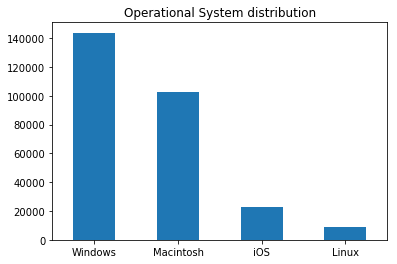

In [33]:
# Distribution for 'os'
df_pd['os'].value_counts().plot(kind='bar', rot=0, title='Operational System distribution');

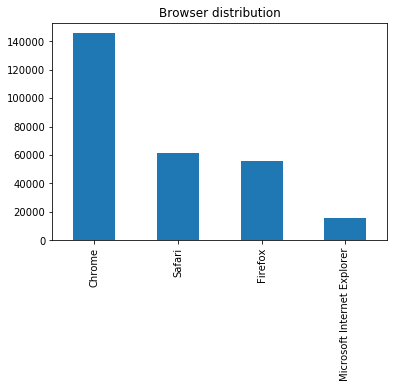

In [34]:
# Distribution for 'browser'
df_pd['browser'].value_counts().plot(kind='bar', title='Browser distribution');

We can see that, except by 'gender', the other categorical features also have imbalanced distributions, like 'page'. One situation that may interfere with 'os' and 'browser' is the fact that one user may use more than one different device or browser to use the streaming service, so let's check if this is happening.

In [35]:
# Checking the combinations of 'userId' and 'os'/'browser'
user_count = df.select('userId').dropDuplicates().count()
userId_os_count = df.select(['userId', 'os']).dropDuplicates().count()
userId_browser_count = df.select(['userId', 'browser']).dropDuplicates().count()

user_count, userId_os_count, userId_browser_count

(225, 225, 225)

The good news is that our users seem to be very loyal to their OSs and browsers, so we don't need to worry about that, we can pick the value of any row for those features.

Lastly, the same way we have users who churned in the middle of the observation window, we may also have new users during this period. The following command will tell us how many they are.

In [36]:
# Looking for late resgistration users
df.select(['userId','registrationDatetime']).where(df.registration > default_start_ts).dropDuplicates().count()

5

After exploring the original dataset, we identified the following structure:

* **artist (string):** artist name (*only available on 'NextSong' page logs*)
* **auth (string):** authentication level (*Cancelled, Guest, Logged In, Logged Out*)
* **firstName (string):** user first name
* **gender (string):** user gender (*F, M*)
* **itemInSession (long):** count of logs from same user for same session
* **lastName (string):** user last name
* **length (double):** song length in seconds (*only available on 'NextSong' page logs*)
* **level (string):** subscription level (*free, paid*)
* **location (string):** user location
* **method (string):** HTTP request method (*GET, PUT*)
* **page (string):** page accessed by the user (*About, Add Friend, Add to Playlist, Cancel, Cancellation Confirmation, Downgrade, Error, Help, Home, Login, Logout, NextSong, Register, Roll Advert, Save Settings, Settings, Submit Downgrade, Submit Registration, Submit Upgrade, Thumbs Up, Thumbs Down, Upgrade*)
* **registration (long):** user registration timestamp
* **sessionId (long):** session identifier
* **song (string):** song name
* **status (long):** HTTP response status code (*200, 307, 404*)
* **ts (long):** log timestamp
* **userAgent (string):** string identifying software used by the user to access the streaming service
* **userId (string):** user identifier

At the end of the analysis step, we were able to gather some insights about the data:

* the whole dataset has no duplicate logs
* *'sessionId'* can't be used to identify unique user activity
* there are logs from 225 users in the dataset, 52 (23%) of them churned at some point during the observation window
* the observation window starts on 1st of October 2018 and ends just before 1st of December 2018 (2 months)
* *'Cancelled'* authentication level maps to *'Cancellation Confirmation'* page and are the last logs of users that churned
* *'method'* and *'status'* map to 'page' values, i.e. are dependent variables
* during the whole period users sticked to the same OSs (Windows, macOS, iOS or Linux) and browsers (IE, Safari, Chrome or Firefox) to access the streaming service
* most of the categorical features and the target label have imbalanced distributions

With this new knowledge, we decided some of the attributes of the original data would not be a good fit as an input to the machine learning model even after feature engineering. The list of them and the reason of letting them out is:

* **artist, song, length:** we decided not to use any of these because they are more related to songs than the users themselves
* **firstName, lastName:** user name should not impact on churn probability
* **itemInSession, sessionId:** since we don't have full understanding of how sessions work, we decided not to use these
* **location:** the number of possible values is too high, even after extracting the State information from it, and as we only have a small number of users in our dataset the are probably underrepresented in this feature, so we decided not to use *'location'*
* **method, status:** both are strongly correlated to *'page'*, which was kept

## Feature Engineering

It’s time to execute the findings of the previous step by running some feature engineering.

The main transformation we need to do is to convert the log-oriented dataset to a user-oriented data set. Log information is arranged over a time window, while user information should be time-independent. It's very important not to let our model learn about underlying relationships in training dataset that will not be available on the unlabeled data it will be applied later, because this may affect real-world performance in a bad way. For example, if we use "played song count" as a feature, since churned users stay for less time using the streaming service they will probably have a lower number for this feature and the model may use this implicit information to fit to the target labels, scoring a higher probability of churn to users with less played songs.

With that in mind, the first steps to perform that transformation are defining the observation start and end timestamps, last authorization level and last subscription level. We will also create some auxiliary columns to calculate the total time span of user activity and the middle point of those periods, which we will later use to create some trend features.

In [37]:
# defining windowing by 'userId'
userId_window_by_ts = Window.partitionBy('userId').orderBy('ts').rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)

# late registration timestamp
df = df.withColumn('firstLogTs', first(col('ts')).over(userId_window_by_ts))
df = df.withColumn('observationStart', when(df.registration > default_start_ts, df.firstLogTs).otherwise(default_start_ts))

# churned users last log timestamp
df = df.withColumn('lastAuth', last(col('auth')).over(userId_window_by_ts))
df = df.withColumn('lastLogTs', last(col('ts')).over(userId_window_by_ts))
df = df.withColumn('observationEnd', when(df.lastAuth == 'Cancelled', df.lastLogTs).otherwise(default_end_ts))

# auxiliary calculated columns
one_day_ms = 24*60*60*1000
df = df.withColumn('observationWindowTotalDays', (col('observationEnd') - col('observationStart'))/one_day_ms)
df = df.withColumn('observationWindowHalfTs', (col('observationEnd') - col('observationStart'))/2 + col('observationStart'))

# user last subscription level
df = df.withColumn('lastSubscriptionLevel', last(col('level')).over(userId_window_by_ts))

Now we will create some new columns from aggregation by 'userId'. The first one is our target variable 'churned' that we will be created based on 'lastAuth', the following ones are user-state variables (last subscription level, gender, OS and browser) and lastly some auxiliary count variables that we will engineer a little further to generate frequencies and trends.

In [38]:
# Creating new features based on aggregations by 'userId'
user_df = df.groupby('userId').agg(
    # target variable
    first(when(col('lastAuth') == 'Cancelled', 1).otherwise(0)).alias('churned'),
    
    # user-state variables
    first(when(col('lastSubscriptionLevel') == 'paid', 1).otherwise(0)).alias('lastSubscriptionLevel'),
    first(when(col('gender') == 'M', 1).otherwise(0)).alias('gender'),
    first(col('observationWindowTotalDays')).alias('observationWindowTotalDays'),    
    first(when(col('os') == 'Windows', 1).otherwise(0)).alias('windows'),
    first(when(col('os') == 'Macintosh', 1).otherwise(0)).alias('macOS'),
    first(when(col('os') == 'iOS', 1).otherwise(0)).alias('iOS'),
    first(when(col('os') == 'Linux', 1).otherwise(0)).alias('linux'),
    first(when(col('browser') == 'Firefox', 1).otherwise(0)).alias('firefox'),
    first(when(col('browser') == 'Chrome', 1).otherwise(0)).alias('chrome'),
    first(when(col('browser') == 'Safari', 1).otherwise(0)).alias('safari'),
    first(when(col('browser') == 'Microsoft Internet Explorer', 1).otherwise(0)).alias('ie'),
    
    # auxiliary counts for frequencies
    f_sum(when(col('page') == 'NextSong', 1).otherwise(0)).alias('songCount'),
    f_sum(when(col('page') == 'Thumbs Up', 1).otherwise(0)).alias('thumbsUpCount'),
    f_sum(when(col('page') == 'Thumbs Down', 1).otherwise(0)).alias('thumbsDownCount'),
    f_sum(when(col('page') == 'Add Friend', 1).otherwise(0)).alias('addFriendCount'),
    f_sum(when(col('page') == 'Add to Playlist', 1).otherwise(0)).alias('addToPlaylistCount'),
    f_sum(when(col('page') == 'Submit Downgrade', 1).otherwise(0)).alias('downgradeCount'),
    f_sum(when(col('page') == 'Submit Upgrade', 1).otherwise(0)).alias('upgradeCount'),
    f_sum(when(col('page') == 'Home', 1).otherwise(0)).alias('homeCount'),
    f_sum(when(col('page') == 'Roll Advert', 1).otherwise(0)).alias('adCount'),
    f_sum(when(col('page') == 'Help', 1).otherwise(0)).alias('helpCount'),
    f_sum(when(col('page') == 'Settings', 1).otherwise(0)).alias('settingsCount'),
    f_sum(when(col('page') == 'Error', 1).otherwise(0)).alias('errorCount'),
    
    # auxiliary counts for trends
    f_sum(when((col('page') == 'NextSong')
              & (col('ts') < col('observationWindowHalfTs')), 1).otherwise(0)).alias('songFirstHalf'),
    f_sum(when((col('page') == 'NextSong') 
              & (col('ts') >= col('observationWindowHalfTs')), 1).otherwise(0)).alias('songSecondHalf'),
    f_sum(when((col('page') == 'Thumbs Up')
              & (col('ts') < col('observationWindowHalfTs')), 1).otherwise(0)).alias('thumbsUpFirstHalf'),
    f_sum(when((col('page') == 'Thumbs Up') 
              & (col('ts') >= col('observationWindowHalfTs')), 1).otherwise(0)).alias('thumbsUpSecondHalf'),
    f_sum(when((col('page') == 'Thumbs Down')
              & (col('ts') < col('observationWindowHalfTs')), 1).otherwise(0)).alias('thumbsDownFirstHalf'),
    f_sum(when((col('page') == 'Thumbs Down') 
              & (col('ts') >= col('observationWindowHalfTs')), 1).otherwise(0)).alias('thumbsDownSecondHalf'),
    f_sum(when((col('page') == 'Add Friend')
              & (col('ts') < col('observationWindowHalfTs')), 1).otherwise(0)).alias('addFriendFirstHalf'),
    f_sum(when((col('page') == 'Add Friend') 
              & (col('ts') >= col('observationWindowHalfTs')), 1).otherwise(0)).alias('addFriendSecondHalf'),
    f_sum(when((col('page') == 'Add to Playlist')
              & (col('ts') < col('observationWindowHalfTs')), 1).otherwise(0)).alias('addToPlaylistFirstHalf'),
    f_sum(when((col('page') == 'Add to Playlist') 
              & (col('ts') >= col('observationWindowHalfTs')), 1).otherwise(0)).alias('addToPlaylistSecondHalf'),
    f_sum(when((col('page') == 'Home')
              & (col('ts') < col('observationWindowHalfTs')), 1).otherwise(0)).alias('homeFirstHalf'),
    f_sum(when((col('page') == 'Home') 
              & (col('ts') >= col('observationWindowHalfTs')), 1).otherwise(0)).alias('homeSecondHalf'),
    f_sum(when((col('page') == 'Roll Advert')
              & (col('ts') < col('observationWindowHalfTs')), 1).otherwise(0)).alias('adFirstHalf'),
    f_sum(when((col('page') == 'Roll Advert') 
              & (col('ts') >= col('observationWindowHalfTs')), 1).otherwise(0)).alias('adSecondHalf'),
    f_sum(when((col('page') == 'Help')
              & (col('ts') < col('observationWindowHalfTs')), 1).otherwise(0)).alias('helpFirstHalf'),
    f_sum(when((col('page') == 'Help') 
              & (col('ts') >= col('observationWindowHalfTs')), 1).otherwise(0)).alias('helpSecondHalf'),
    f_sum(when((col('page') == 'Settings')
              & (col('ts') < col('observationWindowHalfTs')), 1).otherwise(0)).alias('settingsFirstHalf'),
    f_sum(when((col('page') == 'Settings') 
              & (col('ts') >= col('observationWindowHalfTs')), 1).otherwise(0)).alias('settingsSecondHalf'),
    f_sum(when((col('page') == 'Error')
              & (col('ts') < col('observationWindowHalfTs')), 1).otherwise(0)).alias('errorFirstHalf'),
    f_sum(when((col('page') == 'Error') 
              & (col('ts') >= col('observationWindowHalfTs')), 1).otherwise(0)).alias('errorSecondHalf')
)

# new dataframe schema
user_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churned: integer (nullable = true)
 |-- lastSubscriptionLevel: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- observationWindowTotalDays: double (nullable = true)
 |-- windows: integer (nullable = true)
 |-- macOS: integer (nullable = true)
 |-- iOS: integer (nullable = true)
 |-- linux: integer (nullable = true)
 |-- firefox: integer (nullable = true)
 |-- chrome: integer (nullable = true)
 |-- safari: integer (nullable = true)
 |-- ie: integer (nullable = true)
 |-- songCount: long (nullable = true)
 |-- thumbsUpCount: long (nullable = true)
 |-- thumbsDownCount: long (nullable = true)
 |-- addFriendCount: long (nullable = true)
 |-- addToPlaylistCount: long (nullable = true)
 |-- downgradeCount: long (nullable = true)
 |-- upgradeCount: long (nullable = true)
 |-- homeCount: long (nullable = true)
 |-- adCount: long (nullable = true)
 |-- helpCount: long (nullable = true)
 |-- settingsCount: long (nullable = true

As we said previously, we shouldn't have time-dependent features because our model may learn for how much time our users have been using the service and let this influence the predictions. So we will use the count variables to generate new ones with frequencies and trends.

In [39]:
# creating frequencies and trends
user_df = user_df\
.withColumn('songPerDay', col('songCount') / col('observationWindowTotalDays'))\
.withColumn('thumbsUpPerDay', col('thumbsUpCount') / col('observationWindowTotalDays'))\
.withColumn('thumbsDownPerDay', col('thumbsDownCount') / col('observationWindowTotalDays'))\
.withColumn('addFriendPerDay', col('addFriendCount') / col('observationWindowTotalDays'))\
.withColumn('addToPlaylistPerDay', col('addToPlaylistCount') / col('observationWindowTotalDays'))\
.withColumn('downgradePerDay', col('downgradeCount') / col('observationWindowTotalDays'))\
.withColumn('upgradePerDay', col('upgradeCount') / col('observationWindowTotalDays'))\
.withColumn('homePerDay', col('homeCount') / col('observationWindowTotalDays'))\
.withColumn('adPerDay', col('adCount') / col('observationWindowTotalDays'))\
.withColumn('helpPerDay', col('helpCount') / col('observationWindowTotalDays'))\
.withColumn('settingsPerDay', col('settingsCount') / col('observationWindowTotalDays'))\
.withColumn('errorPerDay', col('errorCount') / col('observationWindowTotalDays'))\
.withColumn('songFirstHalfPerDay', col('songFirstHalf') / (col('observationWindowTotalDays') / 2))\
.withColumn('songSecondHalfPerDay', col('songSecondHalf') / (col('observationWindowTotalDays') / 2))\
.withColumn('thumbsUpFirstHalfPerDay', col('thumbsUpFirstHalf') / (col('observationWindowTotalDays') / 2))\
.withColumn('thumbsUpSecondHalfPerDay', col('thumbsUpSecondHalf') / (col('observationWindowTotalDays') / 2))\
.withColumn('thumbsDownFirstHalfPerDay', col('thumbsDownFirstHalf') / (col('observationWindowTotalDays') / 2))\
.withColumn('thumbsDownSecondHalfPerDay', col('thumbsDownSecondHalf') / (col('observationWindowTotalDays') / 2))\
.withColumn('addFriendFirstHalfPerDay', col('addFriendFirstHalf') / (col('observationWindowTotalDays') / 2))\
.withColumn('addFriendSecondHalfPerDay', col('addFriendSecondHalf') / (col('observationWindowTotalDays') / 2))\
.withColumn('addToPlaylistFirstHalfPerDay', col('addToPlaylistFirstHalf') / (col('observationWindowTotalDays') / 2))\
.withColumn('addToPlaylistSecondHalfPerDay', col('addToPlaylistSecondHalf') / (col('observationWindowTotalDays') / 2))\
.withColumn('homeFirstHalfPerDay', col('homeFirstHalf') / (col('observationWindowTotalDays') / 2))\
.withColumn('homeSecondHalfPerDay', col('homeSecondHalf') / (col('observationWindowTotalDays') / 2))\
.withColumn('adFirstHalfPerDay', col('adFirstHalf') / (col('observationWindowTotalDays') / 2))\
.withColumn('adSecondHalfPerDay', col('adSecondHalf') / (col('observationWindowTotalDays') / 2))\
.withColumn('helpFirstHalfPerDay', col('helpFirstHalf') / (col('observationWindowTotalDays') / 2))\
.withColumn('helpSecondHalfPerDay', col('helpSecondHalf') / (col('observationWindowTotalDays') / 2))\
.withColumn('settingsFirstHalfPerDay', col('settingsFirstHalf') / (col('observationWindowTotalDays') / 2))\
.withColumn('settingsSecondHalfPerDay', col('settingsSecondHalf') / (col('observationWindowTotalDays') / 2))\
.withColumn('errorFirstHalfPerDay', col('errorFirstHalf') / (col('observationWindowTotalDays') / 2))\
.withColumn('errorSecondHalfPerDay', col('errorSecondHalf') / (col('observationWindowTotalDays') / 2))\
.withColumn('songPerDayTrend', (col('songSecondHalfPerDay') - col('songFirstHalfPerDay')))\
.withColumn('thumbsUpPerDayTrend', (col('thumbsUpSecondHalfPerDay') - col('thumbsUpFirstHalfPerDay')))\
.withColumn('thumbsDownPerDayTrend', (col('thumbsDownSecondHalfPerDay') - col('thumbsDownFirstHalfPerDay')))\
.withColumn('addFriendPerDayTrend', (col('addFriendSecondHalfPerDay') - col('addFriendFirstHalfPerDay')))\
.withColumn('addToPlaylistPerDayTrend', (col('addToPlaylistSecondHalfPerDay') - col('addToPlaylistFirstHalfPerDay')))\
.withColumn('homePerDayTrend', (col('homeSecondHalfPerDay') - col('homeFirstHalfPerDay')))\
.withColumn('adPerDayTrend', (col('adSecondHalfPerDay') - col('adFirstHalfPerDay')))\
.withColumn('helpPerDayTrend', (col('helpSecondHalfPerDay') - col('helpFirstHalfPerDay')))\
.withColumn('settingsPerDayTrend', (col('settingsSecondHalfPerDay') - col('settingsFirstHalfPerDay')))\
.withColumn('errorPerDayTrend', (col('errorSecondHalfPerDay') - col('errorFirstHalfPerDay')))

user_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churned: integer (nullable = true)
 |-- lastSubscriptionLevel: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- observationWindowTotalDays: double (nullable = true)
 |-- windows: integer (nullable = true)
 |-- macOS: integer (nullable = true)
 |-- iOS: integer (nullable = true)
 |-- linux: integer (nullable = true)
 |-- firefox: integer (nullable = true)
 |-- chrome: integer (nullable = true)
 |-- safari: integer (nullable = true)
 |-- ie: integer (nullable = true)
 |-- songCount: long (nullable = true)
 |-- thumbsUpCount: long (nullable = true)
 |-- thumbsDownCount: long (nullable = true)
 |-- addFriendCount: long (nullable = true)
 |-- addToPlaylistCount: long (nullable = true)
 |-- downgradeCount: long (nullable = true)
 |-- upgradeCount: long (nullable = true)
 |-- homeCount: long (nullable = true)
 |-- adCount: long (nullable = true)
 |-- helpCount: long (nullable = true)
 |-- settingsCount: long (nullable = true

Finally, we can drop the auxiliary variables we've created.

In [40]:
# dropping auxiliary variables
user_df = user_df.drop('observationStart', 'observationEnd', 'observationWindowTotalDays',
                       'songCount', 'songFirstHalf', 'songSecondHalf', 'songFirstHalfPerDay', 'songSecondHalfPerDay',
                       'thumbsUpCount', 'thumbsUpFirstHalf', 'thumbsUpSecondHalf', 'thumbsUpFirstHalfPerDay', 'thumbsUpSecondHalfPerDay',
                       'thumbsDownCount', 'thumbsDownFirstHalf', 'thumbsDownSecondHalf', 'thumbsDownFirstHalfPerDay', 'thumbsDownSecondHalfPerDay',
                       'addFriendCount', 'addFriendFirstHalf', 'addFriendSecondHalf', 'addFriendFirstHalfPerDay', 'addFriendSecondHalfPerDay',
                       'addToPlaylistCount', 'addToPlaylistFirstHalf', 'addToPlaylistSecondHalf', 'addToPlaylistFirstHalfPerDay', 'addToPlaylistSecondHalfPerDay',
                       'downgradeCount',
                       'upgradeCount',
                       'homeCount', 'homeFirstHalf', 'homeSecondHalf', 'homeFirstHalfPerDay', 'homeSecondHalfPerDay',
                       'adCount', 'adFirstHalf', 'adSecondHalf', 'adFirstHalfPerDay', 'adSecondHalfPerDay',
                       'helpCount', 'helpFirstHalf', 'helpSecondHalf', 'helpFirstHalfPerDay', 'helpSecondHalfPerDay',
                       'settingsCount', 'settingsFirstHalf', 'settingsSecondHalf', 'settingsFirstHalfPerDay', 'settingsSecondHalfPerDay',
                       'errorCount', 'errorFirstHalf', 'errorSecondHalf', 'errorFirstHalfPerDay', 'errorSecondHalfPerDay')

user_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churned: integer (nullable = true)
 |-- lastSubscriptionLevel: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- windows: integer (nullable = true)
 |-- macOS: integer (nullable = true)
 |-- iOS: integer (nullable = true)
 |-- linux: integer (nullable = true)
 |-- firefox: integer (nullable = true)
 |-- chrome: integer (nullable = true)
 |-- safari: integer (nullable = true)
 |-- ie: integer (nullable = true)
 |-- songPerDay: double (nullable = true)
 |-- thumbsUpPerDay: double (nullable = true)
 |-- thumbsDownPerDay: double (nullable = true)
 |-- addFriendPerDay: double (nullable = true)
 |-- addToPlaylistPerDay: double (nullable = true)
 |-- downgradePerDay: double (nullable = true)
 |-- upgradePerDay: double (nullable = true)
 |-- homePerDay: double (nullable = true)
 |-- adPerDay: double (nullable = true)
 |-- helpPerDay: double (nullable = true)
 |-- settingsPerDay: double (nullable = true)
 |-- errorPerDay: doubl

## Feature Selection

Now that we have a set of features we think are a good representation of our problem, we will investigate further to analyze the correlation between features and also understand better the impact of each feature on the target variable. Based on the results we may be able to reduce the dimension of our feature space, removing redundancy and making our predictions faster and more accurate.

To perform the analysis, first we will use pandas to create some visualizations and observe the churn proportions by each categorical feature.

In [41]:
# create a Pandas dataframe from the original Spark dataframe
user_df_pd = user_df.toPandas()
user_df_pd.head()

,userId,churned,lastSubscriptionLevel,gender,windows,macOS,iOS,linux,firefox,chrome,...,songPerDayTrend,thumbsUpPerDayTrend,thumbsDownPerDayTrend,addFriendPerDayTrend,addToPlaylistPerDayTrend,homePerDayTrend,adPerDayTrend,helpPerDayTrend,settingsPerDayTrend,errorPerDayTrend
0,100010,0,0,0,0,0,1,0,0,0,...,1.147541,0.163934,0.098361,-0.065574,0.098361,-0.032787,0.262295,0.000000,0.000000,0.000000
1,200002,0,1,1,0,0,1,0,0,0,...,-4.819672,-0.295082,-0.196721,-0.131148,-0.131148,-0.262295,-0.229508,0.000000,-0.098361,0.000000
2,125,1,0,1,0,1,0,0,0,1,...,1.429697,0.000000,0.000000,0.000000,0.000000,0.000000,0.178712,0.000000,0.000000,0.000000
3,124,0,1,0,0,1,0,0,0,1,...,-10.786885,-0.032787,0.163934,0.000000,-0.918033,-1.114754,-0.131148,0.032787,0.065574,-0.131148
4,51,1,1,1,1,0,0,0,0,1,...,-23.653236,-0.735334,0.367667,-2.451113,-1.225556,-3.063891,0.000000,0.000000,-0.245111,-0.122556


In [42]:
def plot_churn_by_binary_feature(df, feature, feature_name, feature_labels):
    s = user_df_pd.loc[:,'churned'].value_counts().div(user_df_pd.shape[0]/100)
    
    df = df.groupby(['churned', feature]).size().reset_index()
    df = df.pivot(index=feature, columns='churned', values=0)
    df = df.div(df.sum(axis=1)/100, axis=0)
    
    fig, ax = plt.subplots()

    ax.bar(feature_labels, df.iloc[:,0], label='Not churned')
    ax.bar(feature_labels, df.iloc[:,1], bottom=df.iloc[:,0], label='Churned')
    
    ax.axhline(y=s[0], xmin=0.0, xmax=1.0, color='k', linestyle='--', linewidth='1', label='Overall Churn Rate')

    ax.set_ylabel('Percentage (%)')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), ncol=5, frameon=False)
    ax.set_title('Churn proportion by ' + feature_name)
    
    plt.yticks(np.arange(0, 101, 10))

    plt.show()

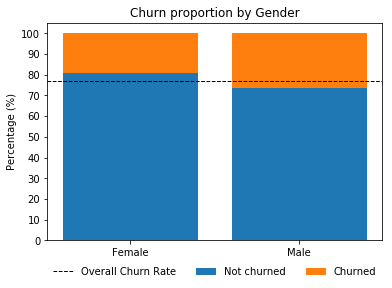

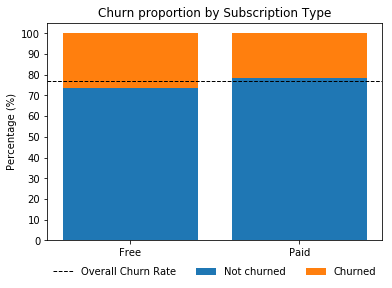

In [43]:
# plot churn proportion by 'gender' and 'lastSubscriptionLevel'
plot_churn_by_binary_feature(user_df_pd, 'gender', 'Gender', ['Female', 'Male'])
plot_churn_by_binary_feature(user_df_pd, 'lastSubscriptionLevel', 'Subscription Type', ['Free', 'Paid'])

In [44]:
def plot_churn_by_categorical_feature(df, feature_list, feature_name, feature_labels):    
    not_churned_values = []
    churned_values = []
    
    for feature in feature_list:
        total = len(user_df_pd[user_df_pd[feature] == 1])
        s = user_df_pd[user_df_pd[feature] == 1]['churned'].value_counts().div(total/100)
        
        not_churned_values.append(s[0])
        churned_values.append(s[1])
        
    s = user_df_pd.loc[:,'churned'].value_counts().div(user_df_pd.shape[0]/100)
    
    fig, ax = plt.subplots()
    
    ax.bar(feature_labels, not_churned_values, label='Not churned')
    ax.bar(feature_labels, churned_values, bottom=not_churned_values, label='Churned')
    
    ax.axhline(y=s[0], xmin=0.0, xmax=1.0, color='k', linestyle='--', linewidth='1', label='Overall Churn Rate')

    ax.set_ylabel('Percentage (%)')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), ncol=5, frameon=False)
    ax.set_title('Churn proportion by ' + feature_name)
    
    plt.yticks(np.arange(0, 101, 10))

    plt.show()

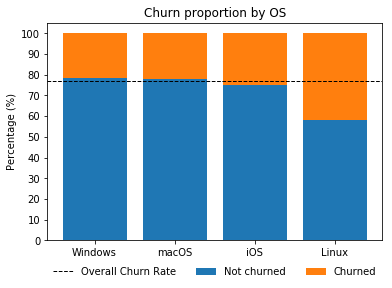

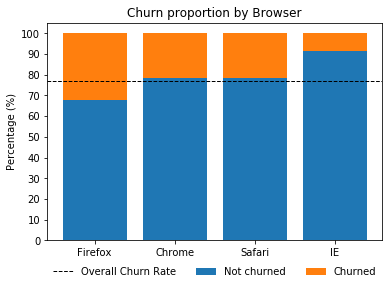

In [45]:
# plot churn proportion by OS and Browser
plot_churn_by_categorical_feature(user_df_pd,
                                  ['windows', 'macOS', 'iOS', 'linux'],
                                  'OS',
                                  ['Windows', 'macOS', 'iOS', 'Linux'])
plot_churn_by_categorical_feature(user_df_pd,
                                  ['firefox', 'chrome', 'safari', 'ie'],
                                  'Browser',
                                  ['Firefox', 'Chrome', 'Safari', 'IE'])

Based on the proportions we could observe, we may assume that 'lastSubscriptionLevel', 'gender', 'windows', 'macOS', 'iOS', 'chrome', 'safari' would have little impact on prediction results, because the proportion of churn by them is almost the same as the overall proportion of churn. That's why we are going to drop them.

In [46]:
user_df = user_df.drop('lastSubscriptionLevel', 'gender', 'windows', 'macOS', 'iOS', 'chrome', 'safari')
user_df_pd = user_df_pd.drop(columns=['lastSubscriptionLevel', 'gender', 'windows', 'macOS', 'iOS', 'chrome', 'safari'])

Next, we will plot a correlation matrix to analyze correlation between the remaining features. If we find two features that are highly correlated (positively or negatively) we can remove one of them since the other will still be able to retain the meaningful properties both of them represented.

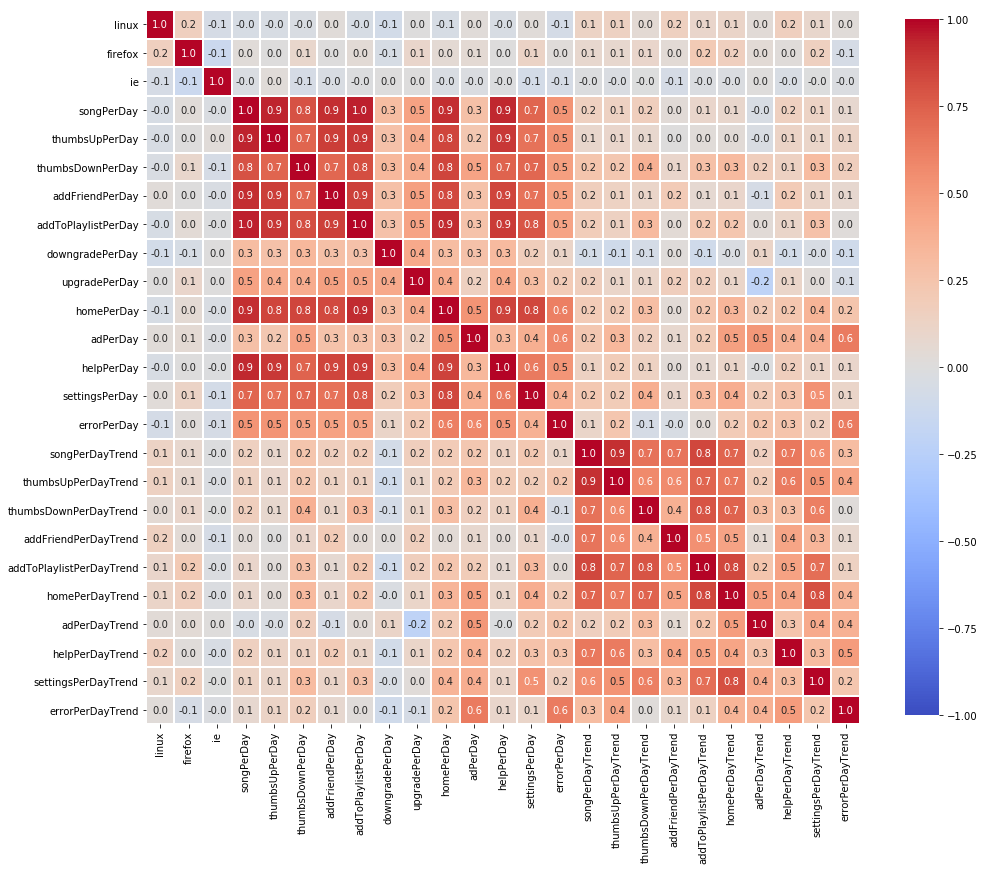

In [47]:
# plot a matrix of correlation between features
plt.figure(figsize=(16,16))
sns.heatmap(user_df_pd.drop(columns=['userId', 'churned']).corr(),
            cmap='coolwarm', annot=True, fmt='.1f', linewidths=1, vmin=-1, vmax=1, square=True, cbar_kws={"shrink": .8})
plt.show()

We can clearly see three main regions of correlation: a 3x3 grid with the remaining categorical features, a 12x12 grid with the frequencies and another 10x10 one with the trends. After analyzing the chart, we've decided to drop 'thumbsUpPerDay', 'thumbsDownPerDay', 'addFriendPerDay', 'addToPlaylistPerDay', 'homePerDay', 'helpPerDay', 'thumbsUpPerDayTrend', 'addToPlaylistPerDayTrend' and 'homePerDayTrend' since they are highly correlated to other features like 'songPerDay' and 'songPerDayTrend'.

In [48]:
# dropping reduntant features
user_df = user_df.drop('thumbsUpPerDay', 'thumbsDownPerDay', 'addFriendPerDay', 'addToPlaylistPerDay', 'homePerDay',
                       'helpPerDay', 'thumbsUpPerDayTrend', 'addToPlaylistPerDayTrend', 'homePerDayTrend')
user_df_pd = user_df_pd.drop(columns=['thumbsUpPerDay', 'thumbsDownPerDay', 'addFriendPerDay', 'addToPlaylistPerDay',
                                      'homePerDay', 'helpPerDay', 'thumbsUpPerDayTrend', 'addToPlaylistPerDayTrend',
                                      'homePerDayTrend'])

This is the result correlation matrix of the remaining features.

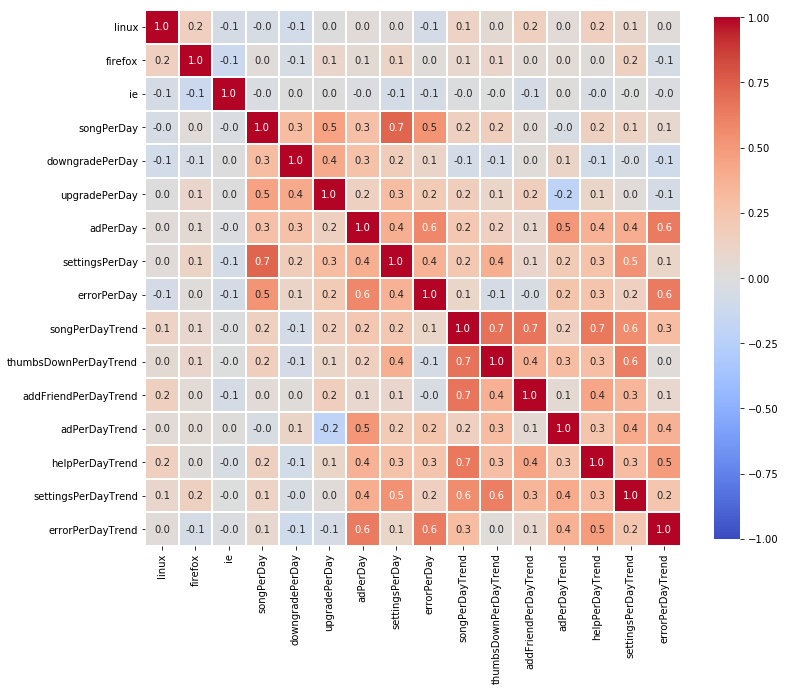

In [49]:
# new correlation matrix
plt.figure(figsize=(12,12))
sns.heatmap(user_df_pd.drop(columns=['userId', 'churned']).corr(),
            cmap='coolwarm', annot=True, fmt='.1f', linewidths=1, vmin=-1, vmax=1, square=True, cbar_kws={"shrink": .8})
plt.show()

In [50]:
# list remaining features
user_df.columns

['userId',
 'churned',
 'linux',
 'firefox',
 'ie',
 'songPerDay',
 'downgradePerDay',
 'upgradePerDay',
 'adPerDay',
 'settingsPerDay',
 'errorPerDay',
 'songPerDayTrend',
 'thumbsDownPerDayTrend',
 'addFriendPerDayTrend',
 'adPerDayTrend',
 'helpPerDayTrend',
 'settingsPerDayTrend',
 'errorPerDayTrend']

At the end, we've reduced an initial set of 25 features to a new one with only 16 features that hopefully still retains the major part of the original information.

## Model Engineering

Now that we have a good candidate set of input features to train our model, it's time to start implementing it. We are going to test some different classification models with their default hyperparameters and use their performance as a baseline to shortlist the best ones, to which we will apply cross-validation with grid search for fine-tuning the hyperparameters. The combination of model and hyperparameters with the best performance will be then selected as our machine learning algorithm for churn prediction.

Let's start creating a train/test split from our new features dataset.

In [53]:
# creating a train/test split
train, test = user_df.randomSplit([0.8, 0.2], 17) 
user_df.count(), train.count(), test.count()

(225, 180, 45)

PySpark's randomSplit doesn't offer any guarantee that the proportion of our target variable in the created subsets are the same as the one from the original dataset, so we should check for these proportions (specially for the train subset) in order to assure it is a good representation of the original data.

In [54]:
# checking churned users proportion for each subset
train.groupBy('churned').count().show()

+-------+-----+
|churned|count|
+-------+-----+
|      1|   39|
|      0|  141|
+-------+-----+



The churn rate for the train dataset is 39/(39+141) = 21.6%, while the whole dataset has a churn rate of 52/225 = 23.1%. The difference is small, so we can say randomSplit had an acceptable performance in terms of distribution of our target variable.

The next step is to define the feature transformation stages that will shape our input features in a way our models are able to perform their jobs correctly. As we highlighted earlier, we had some severe imbalance in some of our original features which were translated to scale differences when we created new features from aggregation, so some of the transformation stages will be responsible for dealing with feature scaling. The other stages will assemble our features as vectors, since those are the expected input formats for PySpark scalers and classifiers.

As we have three different groups of features, we are going to use 3 different strategies for feature scaling:

* **categorical_features (values are 0 or 1):** no need for feature scaling
* **frequency_features (only positive values):** we'll use MinMaxScaler, resulting in values ranging from 0 to 1
* **trend_features (positive and negative values):** we'll use MaxAbsScaler, resulting in values ranging from -1 to 1

In [51]:
# grouping our features by type
categorical_features = ['linux',
                        'firefox',
                        'ie']
frequency_features = ['songPerDay',
                      'downgradePerDay',
                      'upgradePerDay',
                      'adPerDay',
                      'settingsPerDay',
                      'errorPerDay']
trend_features = ['songPerDayTrend',
                  'thumbsDownPerDayTrend',
                  'addFriendPerDayTrend',
                  'adPerDayTrend',
                  'helpPerDayTrend',
                  'settingsPerDayTrend',
                  'errorPerDayTrend']

# feature assembling
frequency_assembler = VectorAssembler(inputCols=frequency_features, outputCol='frequencyVector')
trend_assembler = VectorAssembler(inputCols=trend_features, outputCol='trendVector')

# feature scaling
frequency_scaler = MinMaxScaler(inputCol='frequencyVector', outputCol='scaledFrequencyFeats')
trend_scaler = MaxAbsScaler(inputCol='trendVector', outputCol='scaledTrendFeats')

# model input assembling
all_feats_assembler = VectorAssembler(inputCols=categorical_features + ['scaledFrequencyFeats', 'scaledTrendFeats'],
                                      outputCol='features')

For this first run, we will create similar pipelines with four classifiers: **Logistic Regression, Linear Support Vector Machines, Random Forest and Gradient-boosted Tree.** As we've said, they will all initially run with their default hyperparameters so we can have a baseline to test more complex configurations later.

In [73]:
# classifiers
lr = LogisticRegression(labelCol='churned')
svc = LinearSVC(labelCol='churned')
rf = RandomForestClassifier(labelCol='churned')
gbt = GBTClassifier(labelCol='churned')

# pipelines
common_stages = [frequency_assembler, trend_assembler, frequency_scaler, trend_scaler, all_feats_assembler]

pipeline_lr = Pipeline(stages=common_stages + [lr])
pipeline_svc = Pipeline(stages=common_stages + [svc])
pipeline_rf = Pipeline(stages=common_stages + [rf])
pipeline_gbt = Pipeline(stages=common_stages + [gbt])

Now, let's run a training cycle on all classifiers.

In [74]:
# training logistic regression classifier
start = time.time()
model_lr = pipeline_lr.fit(train)
end = time.time()
print('Training took ' + time.strftime('%M:%S', time.gmtime(end-start)) + ' minutes')

Training took 02:41 minutes


In [75]:
# training linear support vector machines classifier
start = time.time()
model_svc = pipeline_svc.fit(train)
end = time.time()
print('Training took ' + time.strftime('%M:%S', time.gmtime(end-start)) + ' minutes')

Training took 09:43 minutes


In [76]:
# training random forest classifier
start = time.time()
model_rf = pipeline_rf.fit(train)
end = time.time()
print('Training took ' + time.strftime('%M:%S', time.gmtime(end-start)) + ' minutes')

Training took 02:33 minutes


In [77]:
# training gradient-boosted tree classifier
start = time.time()
model_gbt = pipeline_gbt.fit(train)
end = time.time()
print('Training took ' + time.strftime('%M:%S', time.gmtime(end-start)) + ' minutes')

Training took 05:15 minutes


Next, let's apply our trained models to our test subset and then evaluate their performance on predicting churn, using two metrics: Area under precision-recall curve **(AUC-PR)** and **F1-score**.

In [78]:
# perform predictions on test subset
results_lr = model_lr.transform(test)
results_svc = model_svc.transform(test)
results_rf = model_rf.transform(test)
results_gbt = model_gbt.transform(test)

In [108]:
# defining our AUC-PR evaluator
auc_evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR').setLabelCol('churned')
auc_evaluator.getMetricName()

'areaUnderPR'

In [137]:
# AUC-PR evaluation
auc_lr = auc_evaluator.evaluate(results_lr)
auc_svc = auc_evaluator.evaluate(results_svc)
auc_rf = auc_evaluator.evaluate(results_rf)
auc_gbt = auc_evaluator.evaluate(results_gbt)

round(auc_lr, 2), round(auc_svc, 2), round(auc_rf, 2), round(auc_gbt, 2)

(0.8, 0.75, 0.83, 0.84)

In [81]:
# defining our F1-score evaluator
f1_evaluator = MulticlassClassificationEvaluator().setLabelCol('churned')
f1_evaluator.getMetricName()

'f1'

In [138]:
# F1-score evaluation
f1_lr = f1_evaluator.evaluate(results_lr)
f1_svc = f1_evaluator.evaluate(results_svc)
f1_rf = f1_evaluator.evaluate(results_rf)
f1_gbt = f1_evaluator.evaluate(results_gbt)

round(f1_lr, 2), round(f1_svc, 2), round(f1_rf, 2), round(f1_gbt, 2)

(0.77, 0.72, 0.77, 0.82)

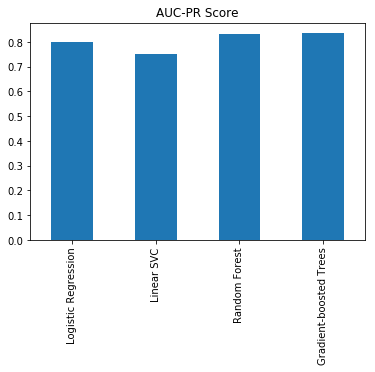

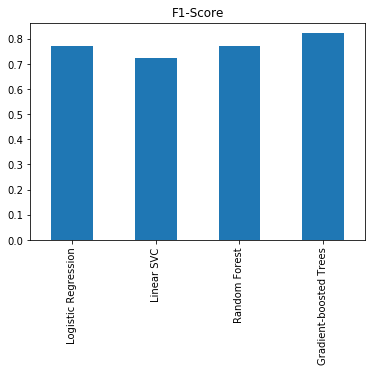

In [134]:
# plotting our evaluation results
classifier_names = ['Logistic Regression', 'Linear SVC', 'Random Forest', 'Gradient-boosted Trees']
pd.DataFrame([auc_lr, auc_svc, auc_rf, auc_gbt], index=classifier_names).plot(kind='bar', legend=False, title='AUC-PR Score');
pd.DataFrame([f1_lr, f1_svc, f1_rf, f1_gbt], index=classifier_names).plot(kind='bar', legend=False, title='F1-Score');

The baseline results are as follows:

|Model                            |AUC-PR|F1-score|
|---------------------------------|------|--------|
|Logistic Regression Classifier   |0.80  |0.77    |
|Linear SVC Classifier            |0.75  |0.72    |
|Random Forest Classifier         |0.83  |0.77    |
|Grandient-boosted Tree Classifier|0.84  |0.82    |

Based on our AUC-PR and F1 scores, we can see that Random Forest and Gradient-boosted Tree classifiers performed slightly better than the others, so we will shortlist them as final candidates for our fine-tuning step. But, before that, since we now have some trained models, let's rank the features by importance for each model and check if there are any other features that we can get rid of. Cross-validation with grid search can be very time consuming so anything we do to make things a little faster is worthwhile.

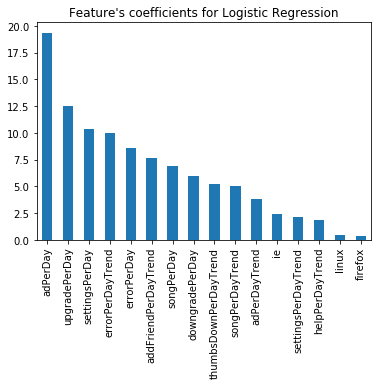

In [127]:
# store feature names
names = categorical_features + frequency_features + trend_features

# plot feature importances for logistic regression classifier
pd_lr_s = pd.Series(model_lr.stages[-1].coefficients, index=names).abs().sort_values(ascending=False)
pd_lr_s.plot(kind='bar', legend=False, title="Feature's coefficients for Logistic Regression");

# create a set of least important features
lr_least = set(pd_lr_s.index[-8:])

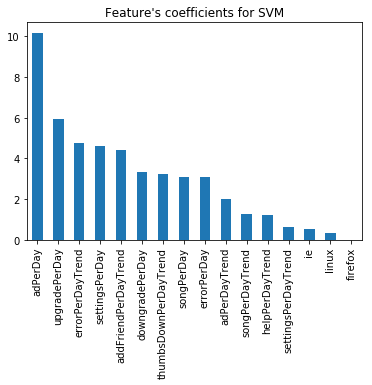

In [128]:
# plot feature importances for linear support vector machine classifier
pd_svc_s = pd.Series(model_svc.stages[-1].coefficients, index=names).abs().sort_values(ascending=False)
pd_svc_s.plot(kind='bar', legend=False, title="Feature's coefficients for SVM");

# create a set of least important features
svc_least = set(pd_svc_s.index[-8:])

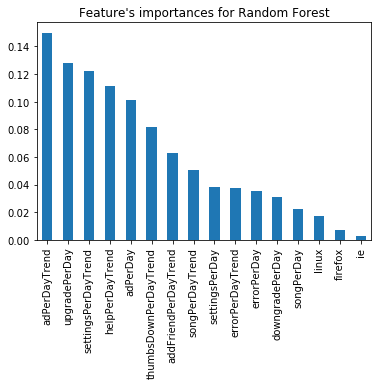

In [129]:
# plot feature importances for random forest classifier
pd_rf_s = pd.Series(model_rf.stages[-1].featureImportances, index=names).abs().sort_values(ascending=False)
pd_rf_s.plot(kind='bar', legend=False, title="Feature's importances for Random Forest");

# create a set of least important features
rf_least = set(pd_rf_s.index[-8:])

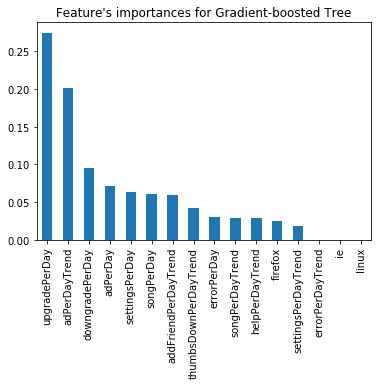

In [130]:
# plot feature importances for gradient-boosted tree classifier
pd_gbt_s = pd.Series(model_gbt.stages[-1].featureImportances, index=names).abs().sort_values(ascending=False)
pd_gbt_s.plot(kind='bar', legend=False, title="Feature's importances for Gradient-boosted Tree");

# create a set of least important features
gbt_least = set(pd_gbt_s.index[-8:])

In [131]:
columns_to_drop = lr_least.intersection(svc_least, rf_least, gbt_least)
columns_to_drop

{'firefox', 'ie', 'linux'}

Not surprisingly, the remaining of our categorical features is present in the least important features set of all four trained models, so we will drop them for the fine-tuning step. For now on, our input dataset will have 13 features.

In [91]:
user_df = user_df.drop(*columns_to_drop)
user_df.columns

['userId',
 'churned',
 'songPerDay',
 'downgradePerDay',
 'upgradePerDay',
 'adPerDay',
 'settingsPerDay',
 'errorPerDay',
 'songPerDayTrend',
 'thumbsDownPerDayTrend',
 'addFriendPerDayTrend',
 'adPerDayTrend',
 'helpPerDayTrend',
 'settingsPerDayTrend',
 'errorPerDayTrend']

## Model Fine-tuning

In this step, we will basically run again our training pipelines for the two classifiers we have shortlisted in the previous step, but additionally performing hyperparameter tuning through cross-validation with grid search. This is one of the most crucial steps and certainly the most time-consuming one of the whole process, so we should make sure that we've already done enough data preprocessing and feature engineering at this point.

In [98]:
# creating a train/test split
train, test = user_df.randomSplit([0.8, 0.2], 17)

# grouping our features by type
frequency_features = ['songPerDay',
                      'downgradePerDay',
                      'upgradePerDay',
                      'adPerDay',
                      'settingsPerDay',
                      'errorPerDay']
trend_features = ['songPerDayTrend',
                  'thumbsDownPerDayTrend',
                  'addFriendPerDayTrend',
                  'adPerDayTrend',
                  'helpPerDayTrend',
                  'settingsPerDayTrend',
                  'errorPerDayTrend']

# feature assembling
frequency_assembler = VectorAssembler(inputCols=frequency_features, outputCol='frequencyVector')
trend_assembler = VectorAssembler(inputCols=trend_features, outputCol='trendVector')

# feature scaling
frequency_scaler = MinMaxScaler(inputCol='frequencyVector', outputCol='scaledFrequencyFeats')
trend_scaler = MaxAbsScaler(inputCol='trendVector', outputCol='scaledTrendFeats')

# model input assembling
all_feats_assembler = VectorAssembler(inputCols=['scaledFrequencyFeats', 'scaledTrendFeats'], outputCol='features')

# classifiers
rf = RandomForestClassifier(cacheNodeIds=True, maxMemoryInMB=2048, labelCol='churned')
gbt = GBTClassifier(cacheNodeIds=True, maxMemoryInMB=2048, labelCol='churned')

# pipelines
common_stages = [frequency_assembler, trend_assembler, frequency_scaler, trend_scaler, all_feats_assembler]

pipeline_rf = Pipeline(stages=common_stages + [rf])
pipeline_gbt = Pipeline(stages=common_stages + [gbt])

# hyperparameters grids
paramgrid_rf = ParamGridBuilder() \
    .addGrid(rf.impurity, ['entropy', 'gini']) \
    .addGrid(rf.maxBins, [16, 32, 64]) \
    .addGrid(rf.maxDepth, [4, 5, 6]) \
    .addGrid(rf.numTrees, [10, 20, 40]) \
    .build()

paramgrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxBins, [16, 32, 64]) \
    .addGrid(gbt.maxDepth, [4, 5, 6]) \
    .addGrid(gbt.maxIter, [10, 20, 40]) \
    .build()

# cross-validation with grid search using f1-score as evaluator
crossval_rf = CrossValidator(estimator=pipeline_rf,
                             estimatorParamMaps=paramgrid_rf,
                             evaluator=f1_evaluator)

crossval_gbt = CrossValidator(estimator=pipeline_gbt,
                             estimatorParamMaps=paramgrid_gbt,
                             evaluator=f1_evaluator)

In [99]:
# perform cross-validation with grid search
start = time.time()
crossvalmodel_rf = crossval_rf.fit(train)
end = time.time()
print('Training took ' + time.strftime('%H:%M:%S', time.gmtime(end-start)) + ' hours')

Training took 01:25:24 hours


In [132]:
# grid search results
params_pd = pd.DataFrame([{p.name: v for p, v in m.items()} for m in crossvalmodel_rf.getEstimatorParamMaps()])
params_pd['score'] = crossvalmodel_rf.avgMetrics
params_pd

,impurity,maxBins,maxDepth,numTrees,score
0,entropy,16,4,10,0.742930
1,entropy,16,4,20,0.776191
2,entropy,16,4,40,0.791328
3,entropy,16,5,10,0.754203
4,entropy,16,5,20,0.796920
5,entropy,16,5,40,0.813667
6,entropy,16,6,10,0.736486
7,entropy,16,6,20,0.812155
8,entropy,16,6,40,0.827325
9,entropy,32,4,10,0.794806


In [101]:
# best parameters combination for random forest classifier
params_pd.iloc[params_pd['score'].idxmax()]

impurity        gini
maxBins           32
maxDepth           6
numTrees          40
score       0.856742
Name: 44, dtype: object

In [136]:
# final random forest classifer results on test subset
result_best_rf = crossvalmodel_rf.transform(test)
round(auc_evaluator.evaluate(result_best_rf), 2), round(f1_evaluator.evaluate(result_best_rf), 2)

(0.9, 0.83)

In [103]:
# perform cross-validation with grid search
start = time.time()
crossvalmodel_gbt = crossval_gbt.fit(train)
end = time.time()
print('Training took ' + time.strftime('%H:%M:%S', time.gmtime(end-start)) + ' hours')

Training took 06:06:49 hours


In [133]:
# grid search results
params_pd = pd.DataFrame([{p.name: v for p, v in m.items()} for m in crossvalmodel_gbt.getEstimatorParamMaps()])
params_pd['score'] = crossvalmodel_gbt.avgMetrics
params_pd

,maxBins,maxDepth,maxIter,score
0,16,4,10,0.836367
1,16,4,20,0.830009
2,16,4,40,0.835262
3,16,5,10,0.832990
4,16,5,20,0.837056
5,16,5,40,0.832990
6,16,6,10,0.828924
7,16,6,20,0.828924
8,16,6,40,0.828924
9,32,4,10,0.833223


In [105]:
# best parameters combination for gradient-boosted tree classifier
params_pd.iloc[params_pd['score'].idxmax()]

maxBins     32.000000
maxDepth     5.000000
maxIter     20.000000
score        0.848354
Name: 13, dtype: float64

In [135]:
# final gradient-boosted tree classifer results on test subset
result_best_gbt = crossvalmodel_gbt.transform(test)
round(auc_evaluator.evaluate(result_best_gbt), 2), round(f1_evaluator.evaluate(result_best_gbt), 2)

(0.84, 0.82)

## Model Evaluation

As initially discussed, Area under precision-recall curve **(AUC-PR)** and **F1-score** were selected as metrics for this evaluation step because our problem is a binary classification, our data is imbalanced and we care much more about the positive class (churned users). The evaluations of the predictions made by the final models on the test subset are as follows:

|Model                                                                          |AUC-PR|F1-score|
|-------------------------------------------------------------------------------|------|--------|
|Random Forest Classifier (impurity='gini', maxBins=32, maxDepth=6, numTrees=40)|0.90  |0.83    |
|Grandient-boosted Tree Classifier (maxBins=32, maxDepth=5, maxIter=20)         |0.84  |0.82    |

Although Random Forest's scores are consistently better (AUC-PR from 0.83 to 0.90, F1-score from 0.77 to 0.83), we haven't seen any improvement for Gradient-boosted Tree Classifier. Actually, a closer look at the parameters reveals that after testing 27 combinations during more than 6 hours the winning one is exactly the default one (which we have previously set as baseline).

The overall low improvement of performance for both models after hyperparameter tuning is probably a direct result of the small size of our dataset. Despite the fact the initial dataset consists of almost 300,000 rows, all that information belongs to only 225 unique users, which are the real input of our models at the end. This meant that our training subset had only 39 positive labels to fit to.

Anyway, our final model based on the Random Forest Classifier has a pretty decent performance on the churn prediction task and should be the selected one.

## Conclusion

Our task was to build a binary classifier, using Machine Learning techniques and the Spark engine through PySpark library, that was able to efficiently predict from user's access logs which customers were about to cancel their subscriptions of a music streaming service, going through the whole process of building a machine learning algorithm (data exploration and analysis using helpful visualizations, feature engineering, model engineering and finally evaluation). The dataset used for this project was a 128MB subset of a larger dataset (with more than 12GB) that could only be processed using Big Data tools like Spark. All steps here could be easily applied to the full dataset using a real Spark cluster deployed in a cloud service.

The most challenging part of this project was certainly the generation of new features through creative engineering of the original input. As the initial data set consisted of activity logs and not user information itself, several transformations needed to be made. In addition, to ensure that our model was not influenced by implicit information, such as customer lifetime, which would not be available in production and also so that it could be applied over a configurable observation window, we needed to make sure that the features were time-independent. The solution was to create features based on usage frequencies and trends.

Some further steps could be taken to improve our results, like: perform further investigation on how sessions are structured and how they could be used to generate new features like session time length, songs per session, etc; use songs and artists' names to generate some insight about users' musical preferences and how this could affect churn rate; and, mainly, train and test the shortlisted models on the full 12GB dataset.

After all, the model we've built could be successfully used to identify in advance users with a high churn risk and thus allow the music streaming company to take appropriate measures to reverse the situation, keep customers and also the business' health.

## External References

1. [Guide to install Spark and use PySpark from Jupyter in Windows](https://bigdata-madesimple.com/guide-to-install-spark-and-use-pyspark-from-jupyter-in-windows/)
2. [Apache Spark 3.0.0 Machine Learning Library (MLlib) Guide](https://spark.apache.org/docs/latest/ml-guide.html)
3. [Httpagentparser by shon](http://shon.github.io/httpagentparser/)